## Data Cleaning Process

### Imports

In [43]:
#loading necessary libraries
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

In [44]:
uber = pd.read_csv('../data/uber.csv')

### Inspecting Database

In [45]:
#view statical summary
uber.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967153,40.767158,-73.963659,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [46]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [47]:
print(f'SHAPE: {uber.shape}')

SHAPE: (200000, 9)


In [48]:
uber.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,52:06.0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Cleaning Databse

#### Invalid Fields

In [49]:
#removal of unecessary cells
uber.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)
uber.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [50]:
#counting null fields
(uber.isnull()).sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

dropoff_longitude & dropoff_latitude have some missing values, we'll drop them

In [51]:
uber = uber[~(uber.isnull())]

---

In [52]:
uber['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

Passenger counts of 0 or 208 are not possible, we can remove them 

In [53]:
uber = uber[~(uber['passenger_count'] == 0) & ~(uber['passenger_count'] > 10)]

---

In [54]:
uber['pickup_longitude'].describe()

count    199290.000000
mean        -72.529899
std          11.434766
min       -1340.648410
25%         -73.992065
50%         -73.981825
75%         -73.967158
max          57.418457
Name: pickup_longitude, dtype: float64

Removing the invalid, longitude and latitude
- Longitudes outside of -180 to 180
- Latitudes outside of -90 to 90

In [55]:
valid_longitude = (-180 <= uber['pickup_longitude']) & (uber['pickup_longitude'] <= 180) & (-180 <= uber['dropoff_longitude']) & (uber['dropoff_longitude'] <= 180)
valid_latitude = (-90 <= uber['pickup_latitude']) & (uber['pickup_latitude'] <= 90) & (-90 <= uber['dropoff_latitude']) & (uber['dropoff_latitude'] <= 90)

Remove any entries where the pickup = dropoff

In [56]:
valid_rides = ~((uber['pickup_longitude'] == uber['dropoff_longitude']) & (uber['pickup_latitude'] == uber['dropoff_latitude']))

In [57]:
#make sure every entry is valid 3 for 3
uber = uber[valid_longitude & valid_latitude & valid_rides]

---

#### Outliers

In [58]:
uber['fare_amount'].describe()

count    193664.000000
mean         11.360518
std           9.762143
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

The min fare price sits at -52, which isn't possible as it shouldn't go bellow 0, we can set in a simple filter to fix this.

In [59]:
uber = uber[uber['fare_amount'] > 1]

With the Q3 being at 12.5, the max of $499 is an outlier

In [60]:
#retrieve a less sensitive, upper / lower bound at (IQR * 3) +- Q
Q1 = uber['fare_amount'].quantile(0.25)
Q3 = uber['fare_amount'].quantile(0.75)

IQR = Q3 - Q1

upper_bound = Q3 + (1.5 * IQR)
lower_bound = Q1 - (1.5 * IQR)

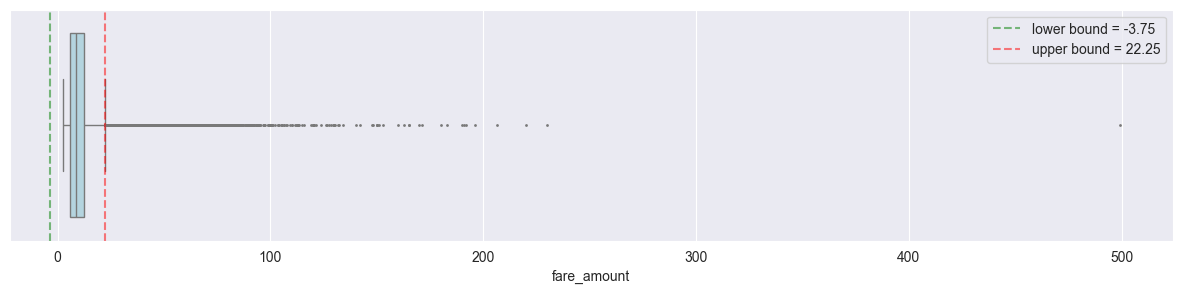

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

plt.figure(figsize=(15,3))
sns.boxplot(uber['fare_amount'], orient='h', color='lightblue', fliersize=1)

#adding in lower / upper bounds
plt.axvline(lower_bound, linestyle='--', color='green', alpha=.5, label=f'lower bound = {lower_bound}')
plt.axvline(upper_bound, linestyle='--', color='red', alpha=.5, label=f'upper bound = {upper_bound}')
plt.legend()

In [62]:
changed = (uber['fare_amount'] > upper_bound).sum() + (uber['fare_amount'] < lower_bound).sum()
total = uber['fare_amount'].sum()

print(f'Removed: {changed / total * 100:f}%')

Removed: 0.755268%


In [63]:
uber = uber[(uber['fare_amount'] < upper_bound) | (uber['fare_amount'] > lower_bound)]

---

#### DateTime

In [64]:
uber['pickup_datetime'].dtype

dtype('O')

In [65]:
uber['pickup_datetime'].head(2)

0    2015-05-07 19:52:06 UTC
1    2009-07-17 20:04:56 UTC
Name: pickup_datetime, dtype: object

Converting to datetime, and split

In [66]:
uber['pickup_datetime'] = pd.to_datetime(uber['pickup_datetime'].str.replace(' UTC', ''), format='%Y-%m-%d %H:%M:%S')

In [67]:
uber['year'] = uber['pickup_datetime'].dt.year
uber['month'] = uber['pickup_datetime'].dt.month
uber['day'] = uber['pickup_datetime'].dt.day

uber['hour'] = uber['pickup_datetime'].dt.hour

In [68]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193641 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        193641 non-null  float64       
 1   pickup_datetime    193641 non-null  datetime64[ns]
 2   pickup_longitude   193641 non-null  float64       
 3   pickup_latitude    193641 non-null  float64       
 4   dropoff_longitude  193641 non-null  float64       
 5   dropoff_latitude   193641 non-null  float64       
 6   passenger_count    193641 non-null  int64         
 7   year               193641 non-null  int32         
 8   month              193641 non-null  int32         
 9   day                193641 non-null  int32         
 10  hour               193641 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(4), int64(1)
memory usage: 14.8 MB


---

#### Storing Data

In [69]:
#selection and order
uber = uber[['fare_amount', 'pickup_longitude', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'day', 'hour']]

In [70]:
uber.to_csv('../data/processed_data.csv', index=False)